In [1]:
# Step 1: Installing the Kaggle library for accessing datasets
# The Kaggle library is being used to download datasets and interact with Kaggle competitions.
!pip install kaggle

# Step 2: Configuring the Kaggle API by placing the Kaggle.json file in the correct directory
# Creating the .kaggle directory if it does not already exist
!mkdir -p ~/.kaggle

# Copying the Kaggle.json file to the .kaggle directory
# The Kaggle.json file is storing the API key and username needed to authenticate with the Kaggle API.
!cp kaggle.json ~/.kaggle/

# Securing the Kaggle.json file by changing its file permissions
# Restricting access to the file to prevent unauthorized users from accessing sensitive information.
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Downloading the dataset from Kaggle
# Using the Kaggle API to download the dataset by specifying the dataset identifier ('omkargurav/face-mask-dataset').
!kaggle datasets download -d omkargurav/face-mask-dataset

# Step 4: Extracting the contents of the downloaded ZIP file
# Importing the ZipFile library for handling ZIP files
from zipfile import ZipFile

# Specifying the path to the ZIP file
zip_path = '/content/face-mask-dataset.zip'

# Opening the ZIP file and extracting its contents
# Using the `extractall()` method to unpack all files into the current directory.
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()  # Specifying a target directory if needed by passing the desired path here
    print('Dataset extracted successfully.')


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 99% 161M/163M [00:07<00:00, 20.8MB/s]
100% 163M/163M [00:07<00:00, 21.6MB/s]
Dataset extracted successfully.


In [2]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

# Defining paths for images
# Specifying the directories where the images with and without masks are stored.
with_mask_dir = '/content/data/with_mask'
without_mask_dir = '/content/data/without_mask'

# Listing image files in each directory
# Collecting all image filenames for "with_mask" and "without_mask" categories.
with_mask_files = os.listdir(with_mask_dir)
without_mask_files = os.listdir(without_mask_dir)

# Printing the count of images in each category
print(f'With Mask Images: {len(with_mask_files)}')
print(f'Without Mask Images: {len(without_mask_files)}')

# Creating labels for each category
# Assigning label `1` for "with_mask" images and `0` for "without_mask" images.
with_mask_labels = [1] * len(with_mask_files)
without_mask_labels = [0] * len(without_mask_files)

# Combining all labels into a single list
# Merging the labels from both categories into one dataset.
labels = with_mask_labels + without_mask_labels


With Mask Images: 3725
Without Mask Images: 3828


In [3]:
# Preparing images with consistent channel dimensions
def preprocess_images(image_dir, image_files):
    # Initializing an empty list to store the processed image data
    data = []
    # Iterating through the list of image filenames
    for img_file in image_files:
        # Opening each image from the directory
        image = Image.open(os.path.join(image_dir, img_file))
        # Resizing the image to 128x128 dimensions for consistency
        image = image.resize((128, 128))
        # Converting the image to RGB format to ensure 3 channels
        image = image.convert("RGB")
        # Converting the image to a NumPy array
        image = np.array(image)
        # Appending the processed image to the data list
        data.append(image)
    # Returning the processed image data
    return data

# Loading and preprocessing images for each category
# Preparing the "with_mask" image dataset
with_mask_data = preprocess_images(with_mask_dir, with_mask_files)
# Preparing the "without_mask" image dataset
without_mask_data = preprocess_images(without_mask_dir, without_mask_files)

# Combining datasets from both categories
# Merging the "with_mask" and "without_mask" datasets into a single array
data = np.array(with_mask_data + without_mask_data)
# Converting the label list into a NumPy array
labels = np.array(labels)

# Normalizing image pixel values
# Scaling the pixel values to the range [0, 1] by dividing by 255.0
data = data / 255.0

# Splitting the data into training and testing sets
# Using an 80-20 split for training and testing, and setting a random seed for reproducibility
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Printing the shapes of the training and testing datasets
print(f'Training Data Shape: {X_train.shape}')
print(f'Test Data Shape: {X_test.shape}')


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Training Data Shape: (6042, 128, 128, 3)
Test Data Shape: (1511, 128, 128, 3)


In [4]:
# Importing the ImageDataGenerator class for augmenting image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Creating an instance of ImageDataGenerator for data augmentation
# Applying various transformations to enhance the diversity of training data
data_gen = ImageDataGenerator(
    rotation_range=20,           # Rotating images randomly within a range of 20 degrees
    zoom_range=0.15,             # Randomly zooming images by up to 15%
    width_shift_range=0.2,       # Shifting images horizontally by up to 20% of the width
    height_shift_range=0.2,      # Shifting images vertically by up to 20% of the height
    shear_range=0.15,            # Applying a shearing transformation by up to 15%
    horizontal_flip=True,        # Flipping images horizontally to simulate real-world variations
    fill_mode="nearest"          # Filling any gaps created by transformations with the nearest pixel values
)

# Generating augmented training data
# Feeding the training data (images and labels) into the generator for real-time augmentation
train_data_gen = data_gen.flow(
    X_train,                     # Input images for training
    Y_train,                     # Corresponding labels for the images
    batch_size=32                # Setting the batch size to 32 for training
)


In [5]:
# Importing necessary modules for building and customizing the model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Loading MobileNetV2 as the base model for feature extraction
# Using pre-trained weights from the "imagenet" dataset to leverage transfer learning
base_model = MobileNetV2(
    weights="imagenet",            # Loading weights pre-trained on the ImageNet dataset
    include_top=False,             # Excluding the top layers to allow customization
    input_tensor=Input(shape=(128, 128, 3))  # Defining the input tensor with a shape of 128x128x3
)

# Adding custom layers for multitask learning
# Extending the base model with additional layers for our specific task
head_model = base_model.output
head_model = GlobalAveragePooling2D()(head_model)  # Applying global average pooling to reduce feature dimensions
head_model = Dense(128, activation="relu")(head_model)  # Adding a fully connected layer with 128 neurons
head_model = Dropout(0.5)(head_model)             # Applying dropout to prevent overfitting
head_model = Dense(64, activation="relu")(head_model)   # Adding another fully connected layer with 64 neurons
head_model = Dropout(0.5)(head_model)             # Applying another dropout layer
head_model = Dense(2, activation="softmax")(head_model)  # Final output layer for binary classification (Mask/No Mask)

# Creating the complete model
# Connecting the base model and custom head to form the final architecture
model = Model(inputs=base_model.input, outputs=head_model)

# Freezing the layers of the base model
# Preventing the base model's weights from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model
# Setting up the optimizer, loss function, and evaluation metric for training
model.compile(
    optimizer='adam',                          # Using Adam optimizer for adaptive learning
    loss='sparse_categorical_crossentropy',    # Using sparse categorical crossentropy for binary classification
    metrics=['accuracy']                       # Tracking accuracy as the evaluation metric
)

# Printing the model summary
# Displaying the architecture, layers, and number of parameters
print(model.summary())


<ipython-input-5-7bd3116be272>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 64, 64, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 64, 64, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 64, 64, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 64, 64, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 64, 64, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 64, 64, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 64, 64, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 64, 64, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 64, 64, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 64, 64, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 65, 65, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 32, 32, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,430,338 (9.27 MB)

 Trainable params: 172,354 (673.26 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [6]:
# Training the model
# Using the fit method to train the model on the augmented training data
history = model.fit(
    train_data_gen,               # Feeding the augmented training data generator
    validation_data=(X_test, Y_test),  # Providing the validation data (test set) for accuracy monitoring
    epochs=10                     # Setting the number of training epochs to 10
)

# Evaluating the model
# Calculating the final loss and accuracy on the test dataset
loss, accuracy = model.evaluate(
    X_test,                       # Input images for evaluation
    Y_test                        # Corresponding true labels
)

# Printing the test accuracy
# Displaying the model's performance in terms of accuracy on unseen data
print(f'Test Accuracy: {accuracy}')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


189/189 ━━━━━━━━━━━━━━━━━━━━ 126s 631ms/step - accuracy: 0.8422 - loss: 0.4080 - val_accuracy: 0.9801 - val_loss: 0.0566
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 118s 621ms/step - accuracy: 0.9517 - loss: 0.1352 - val_accuracy: 0.9841 - val_loss: 0.0538
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 117s 614ms/step - accuracy: 0.9595 - loss: 0.1149 - val_accuracy: 0.9821 - val_loss: 0.0480
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 148s 643ms/step - accuracy: 0.9674 - loss: 0.1047 - val_accuracy: 0.9828 - val_loss: 0.0505
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 139s 626ms/step - accuracy: 0.9690 - loss: 0.0906 - val_accuracy: 0.9848 - val_loss: 0.0414
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 120s 631ms/step - accuracy: 0.9683 - loss: 0.0888 - val_accuracy: 0.9768 - val_loss: 0.0542
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 121s 634ms/step - accuracy: 0.9730 - loss: 0.0914 - val_accuracy: 0.9874 - val_loss: 0.0457
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 139s 610ms/step - accuracy: 0.9689 - loss: 0.08

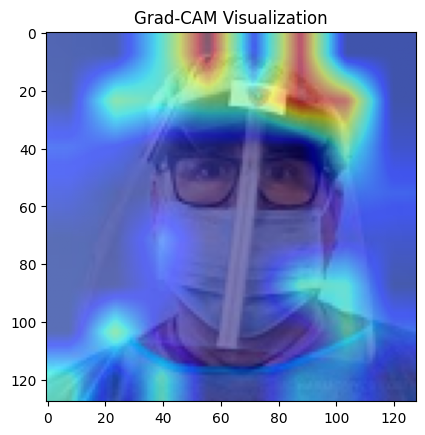

In [7]:
# Importing necessary modules for Grad-CAM implementation
import tensorflow as tf
import cv2

# Defining a function to compute Grad-CAM visualizations
# Highlighting important regions in an image that influence the model's prediction
def grad_cam(input_model, img_array, layer_name):
    # Creating a sub-model to retrieve feature map outputs and predictions
    grad_model = Model(
        [input_model.inputs],  # Input to the original model
        [input_model.get_layer(layer_name).output, input_model.output]  # Layer of interest and final output
    )

    # Using GradientTape for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  # Extracting feature maps and predictions
        loss = predictions[:, np.argmax(predictions[0])]   # Focusing on the class with the highest predicted probability

    # Computing gradients of the loss with respect to the convolutional outputs
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Averaging the gradients for each feature map

    # Processing the feature map outputs
    conv_outputs = conv_outputs.numpy()[0]  # Extracting the feature maps as a NumPy array
    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]  # Weighting feature maps by their importance

    # Generating the Grad-CAM heatmap
    cam = np.mean(conv_outputs, axis=-1)      # Combining weighted feature maps into a single heatmap
    cam = np.maximum(cam, 0)                  # Applying ReLU to keep only positive values
    cam = cv2.resize(cam, (128, 128))         # Resizing the heatmap to match the input image size
    cam = cam / cam.max()                     # Normalizing the heatmap to range [0, 1]

    return cam

# Testing Grad-CAM on a sample image
test_img = X_test[0].reshape(1, 128, 128, 3)  # Selecting the first test image and reshaping for model input
cam = grad_cam(model, test_img, 'block_13_expand_relu')  # Using a specific layer (e.g., 'block_13_expand_relu')

# Visualizing the Grad-CAM heatmap
plt.imshow(X_test[0])                          # Displaying the original image
plt.imshow(cam, cmap='jet', alpha=0.5)         # Overlaying the Grad-CAM heatmap with transparency
plt.title('Grad-CAM Visualization')           # Adding a title to the plot
plt.show()                                     # Rendering the visualization


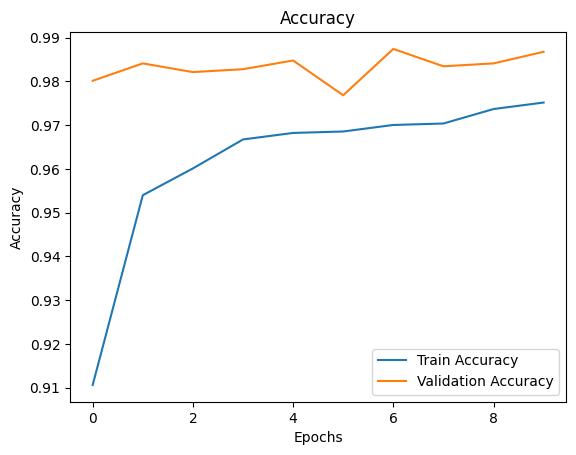

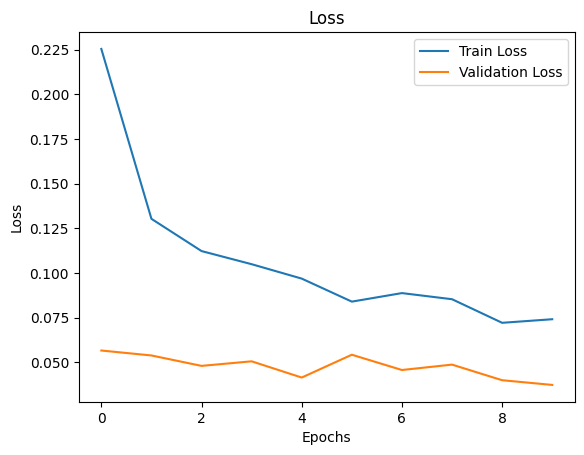

In [8]:
# Plotting accuracy and loss graphs to evaluate model performance over epochs
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.plot(
    history.history['accuracy'],       # Plotting training accuracy values over epochs
    label='Train Accuracy'             # Labeling the training accuracy curve
)
plt.plot(
    history.history['val_accuracy'],   # Plotting validation accuracy values over epochs
    label='Validation Accuracy'        # Labeling the validation accuracy curve
)
plt.legend()                           # Adding a legend to differentiate the curves
plt.title('Accuracy')                  # Setting the title of the accuracy plot
plt.xlabel('Epochs')                   # Adding an x-axis label for clarity
plt.ylabel('Accuracy')                 # Adding a y-axis label for clarity
plt.show()                             # Displaying the accuracy plot

# Plotting training and validation loss
plt.plot(
    history.history['loss'],           # Plotting training loss values over epochs
    label='Train Loss'                 # Labeling the training loss curve
)
plt.plot(
    history.history['val_loss'],       # Plotting validation loss values over epochs
    label='Validation Loss'            # Labeling the validation loss curve
)
plt.legend()                           # Adding a legend to differentiate the curves
plt.title('Loss')                      # Setting the title of the loss plot
plt.xlabel('Epochs')                   # Adding an x-axis label for clarity
plt.ylabel('Loss')                     # Adding a y-axis label for clarity
plt.show()                             # Displaying the loss plot


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
The person in the image is not wearing a mask.


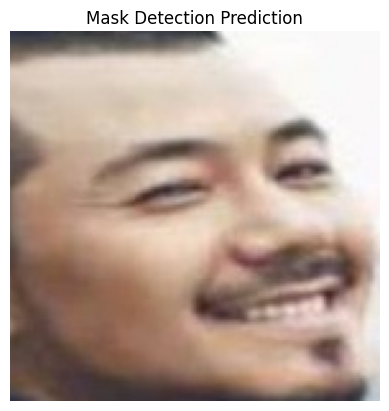

In [11]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Ensuring the pre-trained model is loaded correctly
# model = tf.keras.models.load_model('your_model_path')  # Uncomment this line if the model isn't already loaded

# Defining a function for preprocessing an input image
def preprocess_input_image(image_path):
    # Loading the image from the given path and resizing it to the required dimensions (128x128)
    img = image.load_img(image_path, target_size=(128, 128))
    # Converting the image to a NumPy array for processing
    img_array = image.img_to_array(img)
    # Expanding dimensions to add a batch axis, as the model expects input in batches
    img_array = np.expand_dims(img_array, axis=0)
    # Normalizing pixel values to the range [0, 1] for consistency with model training
    img_array = img_array / 255.0
    return img_array  # Returning the processed image array

# Creating a function to test a new image for mask detection
def test_image(image_path):
    # Preprocessing the input image using the defined function
    img_array = preprocess_input_image(image_path)

    # Generating predictions using the trained model
    prediction = model.predict(img_array)

    # Extracting the predicted class (0 for No Mask, 1 for Mask)
    predicted_label = np.argmax(prediction)

    # Printing the prediction result
    if predicted_label == 1:
        print("The person in the image is wearing a mask.")
    else:
        print("The person in the image is not wearing a mask.")

    # Optionally, displaying the input image along with the prediction
    img = cv2.imread(image_path)            # Reading the image file
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converting BGR to RGB for visualization
    plt.imshow(img)                         # Displaying the image
    plt.title("Mask Detection Prediction")  # Adding a title to indicate prediction
    plt.axis('off')                         # Hiding the axes for cleaner visualization
    plt.show()

    # Example: Testing the model with a new image
# Updating this with the correct path to your test image
# Assuming the test image is located within the 'data/without_mask' directory
image_path = '/content/data/without_mask/without_mask_28.jpg'
test_image(image_path)                      # Running the test on the provided image                            # Showing the image with the prediction

                   # Running the test on the provided image


In [12]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload an image


Saving with_mask_24.jpg to with_mask_24.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
The person in the image is wearing a mask.


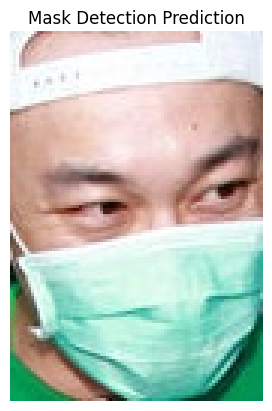

In [14]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Defining a function for preprocessing the input image
def preprocess_input_image(image_path):
    # Loading the image from the given file path and resizing it to (128x128)
    img = image.load_img(image_path, target_size=(128, 128))
    # Converting the image into a NumPy array for processing
    img_array = image.img_to_array(img)
    # Expanding the dimensions of the image to match the model's expected input shape
    img_array = np.expand_dims(img_array, axis=0)
    # Normalizing the image data by scaling pixel values to the range [0, 1]
    img_array = img_array / 255.0
    return img_array  # Returning the processed image array

# Defining a function to test the model with a new image
def test_image(image_path):
    # Preprocessing the image using the preprocessing function
    img_array = preprocess_input_image(image_path)

    # Using the pre-trained model to make predictions on the input image
    prediction = model.predict(img_array)

    # Determining the predicted label (0 for No Mask, 1 for Mask)
    predicted_label = np.argmax(prediction)

    # Printing the prediction result
    if predicted_label == 1:
        print("The person in the image is wearing a mask.")
    else:
        print("The person in the image is not wearing a mask.")

    # Reading the input image file for visualization
    img = cv2.imread(image_path)
    # Converting the image from BGR (OpenCV default) to RGB format for display
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Displaying the image along with the prediction
    plt.imshow(img)
    plt.title("Mask Detection Prediction")  # Adding a title to describe the result
    plt.axis('off')  # Hiding the axes for a cleaner view
    plt.show()  # Showing the image with the prediction

# Specifying the file path to the test image
image_path = '/content/with_mask_24.jpg'  # Replace with the path to your test image
# Calling the function to test the model with the provided image
test_image(image_path)


In [16]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload an image

Saving without_mask_175.jpg to without_mask_175.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
The person in the image is not wearing a mask.


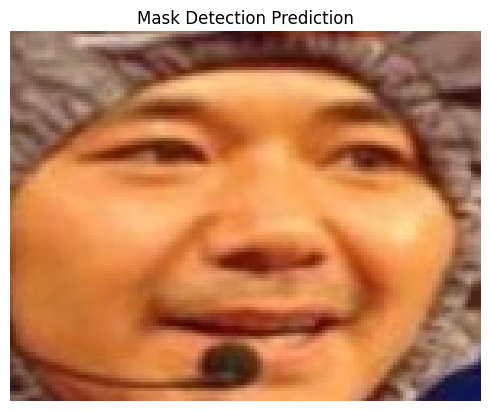

In [17]:
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Function to preprocess input image
def preprocess_input_image(image_path):
    # Loading the image and resizing it to 128x128 to match the model's input size
    img = image.load_img(image_path, target_size=(128, 128))
    # Converting the loaded image into a NumPy array for further processing
    img_array = image.img_to_array(img)
    # Expanding the image array to add a batch dimension (the model expects a batch of images)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalizing the image by dividing the pixel values by 255 to scale them to the range [0, 1]
    img_array = img_array / 255.0
    return img_array  # Returning the preprocessed image array

# Function to test the model with a new image
def test_image(image_path):
    # Preprocessing the input image using the defined function
    img_array = preprocess_input_image(image_path)

    # Using the model to make predictions on the preprocessed image
    prediction = model.predict(img_array)

    # Determining the predicted label (0 for No Mask, 1 for Mask) by finding the index with the highest probability
    predicted_label = np.argmax(prediction)

    # Displaying the result based on the predicted label
    if predicted_label == 1:
        print("The person in the image is wearing a mask.")
    else:
        print("The person in the image is not wearing a mask.")

    # Optionally displaying the original image along with the prediction result
    img = cv2.imread(image_path)
    # Converting the image from BGR (OpenCV default) to RGB format for correct display in matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Displaying the image and showing the prediction result in the title
    plt.imshow(img)
    plt.title("Mask Detection Prediction")  # Title of the plot
    plt.axis('off')  # Hiding the axes for a cleaner visualization
    plt.show()  # Showing the image with the prediction

# Path to the test image (ensure this is the correct path)
image_path = '/content/without_mask_175.jpg'  # Replace with your test image path
# Calling the function to test the model with the given image
test_image(image_path)
